<a href="https://colab.research.google.com/github/eojo91/ds2_2023_summer_ml_project1/blob/Kyungheui.Cho/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 : Human Activity Recognition

### 프로젝트 제출 가이드
- 제출 기한: 2023년 8월 4일 (금) 자정
- 제출 내용: `4. 구현` 셀에 `LRClassifier` 변수를 구현하고, `Project1.ipynb`를 제출
- 제출 방법: `ta_ml@hcs.snu.ac.kr`로 이메일 제출 (여러 번 제출시 마지막 버전을 사용)
- 메일 제목: `X조 ML Project 1`
- 점수 비중: 10%


### 채점 기준 [총 100점]
1. `5. 테스트` 셀이 잘 실행되어야 합니다. [+100점]
2. `LRClassifier`는 Logistic Regression을 이용해서 분류를 수행해야 합니다. [-100점]
3. 띄어쓰기, 주석, Data Plotting 등 실행과 상관없는 부분은 수정이 가능하고, 실행과 관련된 부분은 `4. 구현` 셀만 수정하여야 합니다. [-50점]


### 참고 사항
1. Project 1에서 성능은 채점 기준에 들어가지 않습니다.
2. `sklearn` 외의 다른 라이브러리를 사용해도 됩니다.

---
## 목차
1. 프로젝트 개요
2. 데이터<br/>
  2.1. 데이터 로드 방법<br/>
  2.2. 데이터 개요<br/>
  2.3. 데이터 샘플 예제<br/>
3. `KNNClassifier` 예제
4. 구현
5. 테스트

### 1. 프로젝트 개요
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

<img src="https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>그림 1. Walking, Running 예제 데이터</div>

### Import libraries

In [ ]:
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
%matplotlib inline

### 2. 데이터
#### 2.1. 데이터 로드

In [ ]:
def load_data(local=False): # Local에서 실행할땐 True로 설정
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    X, Y = np.stack(df['Data']), np.stack(df['Motion'])  # np.stack : pandas.Series => np.ndarray
    groups = np.stack(df['Subject'])  # For LeaveOneGroupOut

    return X, Y, groups # X : 가속도 값, Y : 모션, groups : 사람이 다르면 데이터 분포가 달라. subject 단위로 train/test를 나눠야 함.


In [ ]:
X, Y, groups = load_data(local=False)

print(X.shape, Y.shape, groups.shape)

(13940, 500, 3) (13940,) (13940,)


In [ ]:
# 구글 코랩에서는 한글 폰트를 기본으로 포함하지 않기 때문에 다음과 같이 설정 후 런타임 다시 시작.

# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# matplotlib의 폰트를 Nanum으로 설정
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

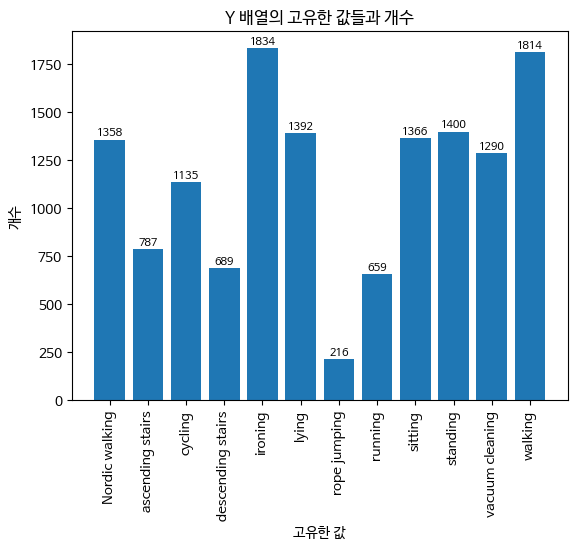

In [ ]:
# Y 배열에서 고유한 값들과 각 값들의 개수를 구하기
unique_values, value_counts = np.unique(Y, return_counts=True)

# 막대 그래프 그리기
plt.bar(unique_values, value_counts)

# 각 막대 위에 해당하는 y 값 표시
# plt.text 함수는 각 막대 위에 y 값을 표시합니다.
# unique_values[i]는 x 위치, v + 20는 y 위치(막대의 끝 위에 위치시키기 위해 20를 더했습니다),
# str(v)는 표시할 텍스트입니다. ha='center'는 텍스트를 가로 중앙에 맞춥니다.
for i, v in enumerate(value_counts):
    plt.text(unique_values[i], v + 20, str(v), ha='center', fontsize=8)

# 그래프에 제목과 축 레이블 추가
plt.title("Y 배열의 고유한 값들과 개수")
plt.xlabel("고유한 값")
plt.ylabel("개수")

# x축 레이블 세로로 표시하기
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


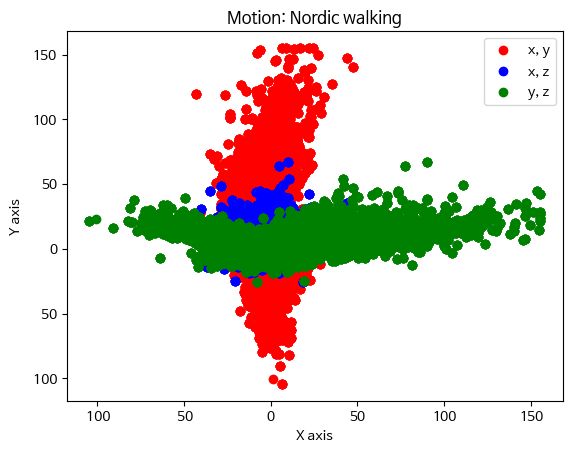

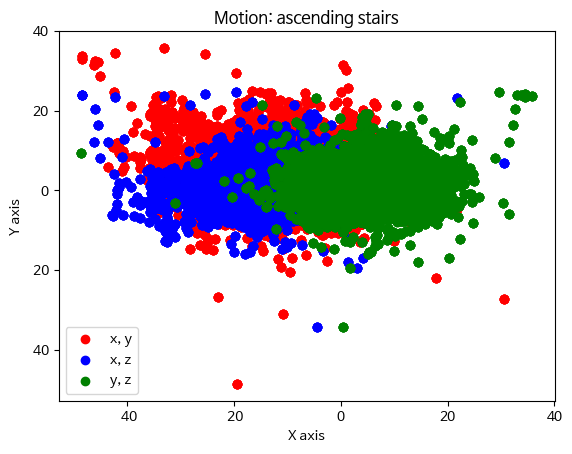

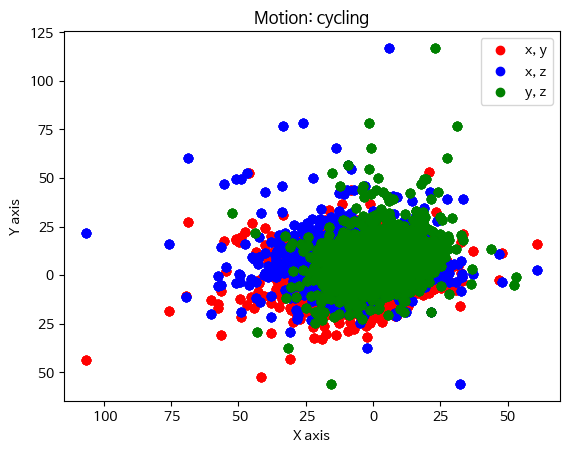

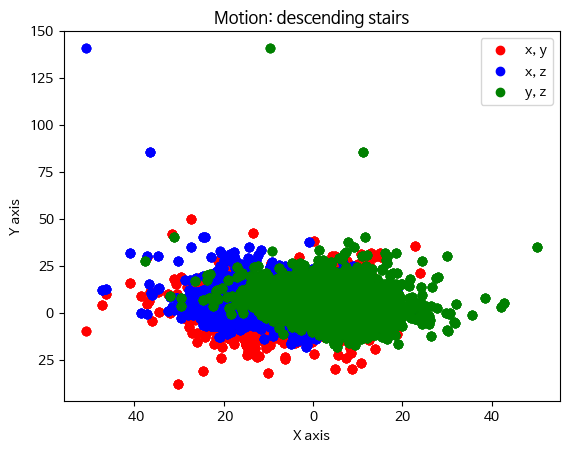

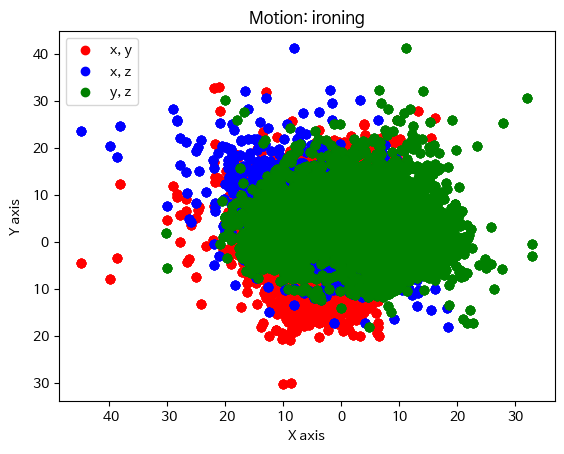

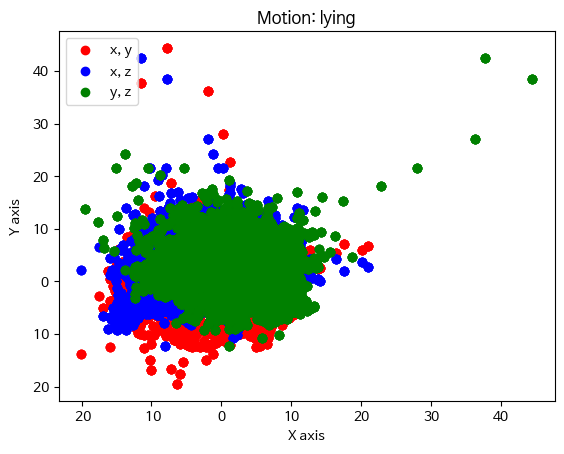

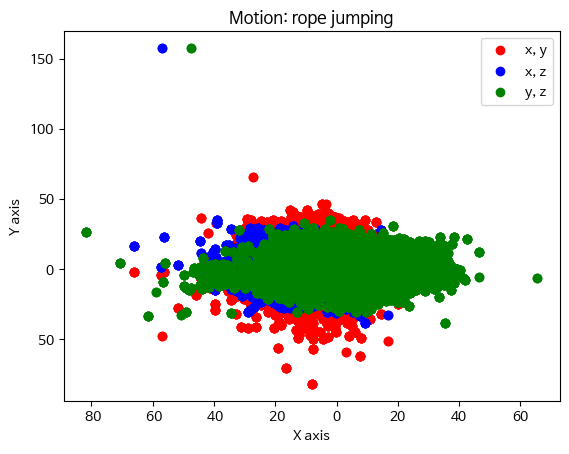

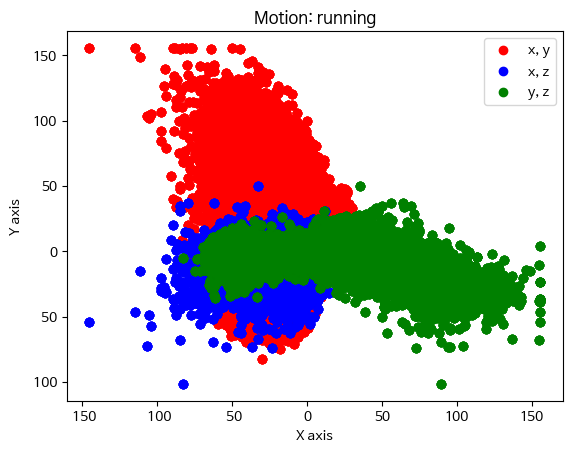

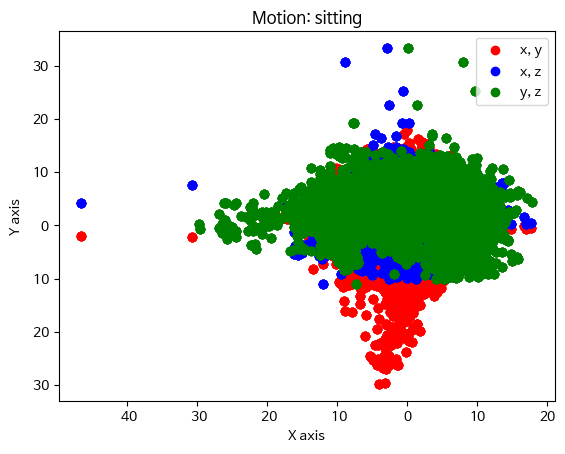

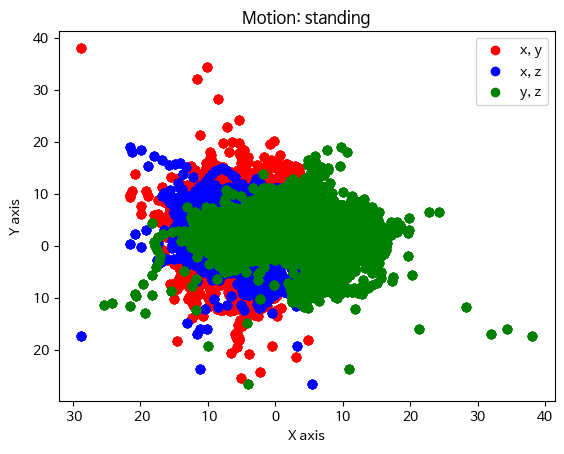

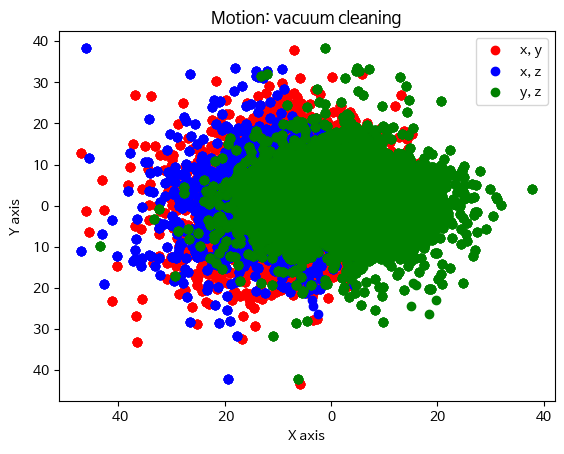

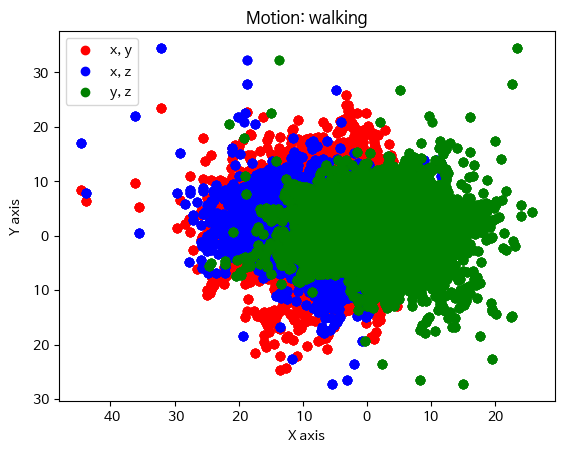

In [ ]:

# y 값의 종류를 확인합니다.
unique_y = np.unique(Y)

# 각 y 값의 종류별로 그래프를 그리고, 각 그래프에는 x 값의 x, y, z별 산포를 표현합니다.
for y_val in unique_y:
    # y 값이 해당 y_val인 데이터를 선택합니다.
    y_mask = (Y == y_val)
    x_data = X[y_mask]

    # 각 축의 데이터를 가져옵니다.
    x_axis = x_data[:, :, 0]  # x 축 데이터
    y_axis = x_data[:, :, 1]  # y 축 데이터
    z_axis = x_data[:, :, 2]  # z 축 데이터

    # 그래프를 그립니다.
    plt.figure()
    plt.scatter(x_axis, y_axis, c='r', label='x, y')  # x, y 축 데이터를 빨간색으로 표시
    plt.scatter(x_axis, z_axis, c='b', label='x, z')  # x, z 축 데이터를 파란색으로 표시
    plt.scatter(y_axis, z_axis, c='g', label='y, z')  # y, z 축 데이터를 초록색으로 표시
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(f"Motion: {y_val}")
    plt.legend()
    plt.show()


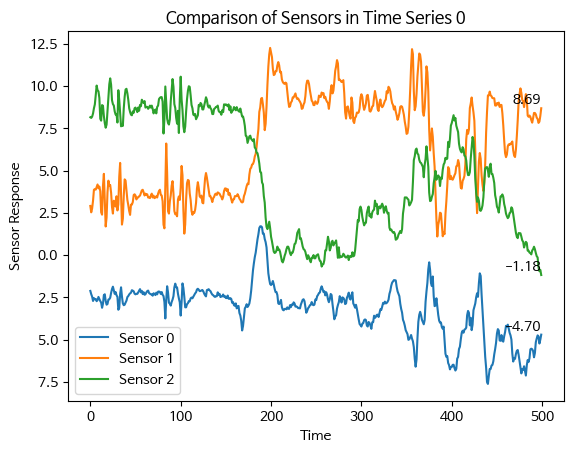

In [ ]:
time_series_index = 0 # 예를 들어, 첫 번째 측정 시리즈 선택
for sensor_index in range(3):
    sensor_data = X[time_series_index, :, sensor_index]
    plt.plot(sensor_data, label=f'Sensor {sensor_index}')
    y_value = sensor_data[-1] # 마지막 y 값
    plt.text(len(sensor_data) - 1, y_value, f'{y_value:.2f}', verticalalignment="bottom", horizontalalignment="right")
plt.xlabel("Time")
plt.ylabel("Sensor Response")
plt.legend()
plt.title("Comparison of Sensors in Time Series 0")
plt.show()



#### 2.2. 데이터 개요
- 각 샘플은 `Subject`, `Data`, `Motion` 값으로 이루어져 있습니다.
  - `Subject`: 실험자 ID (`int` 타입)
  - `Data`: (500, 3) 형태의 `numpy array` (`numpy array` 타입)
    - 5초 동안 100Hz로 3축 데이터를 모으면 (500, 3) 형태의 데이터가 됩니다.
  - `Motion`: 실험자의 실제 행동 ( `str` 타입)
    - ex. `walking`, `running`, ...

- `Data` 정보를 가지고 `Motion` 값을 유추해야합니다.
- `Subject`는 Cross Validation에 활용하기 위해 제공됩니다. Cross Validation의 경우 `CrossValidation.ipynb`를 참고해주세요.

#### 2.3. 데이터 샘플 예제

<ipython-input-17-bab0257733f5>:17: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


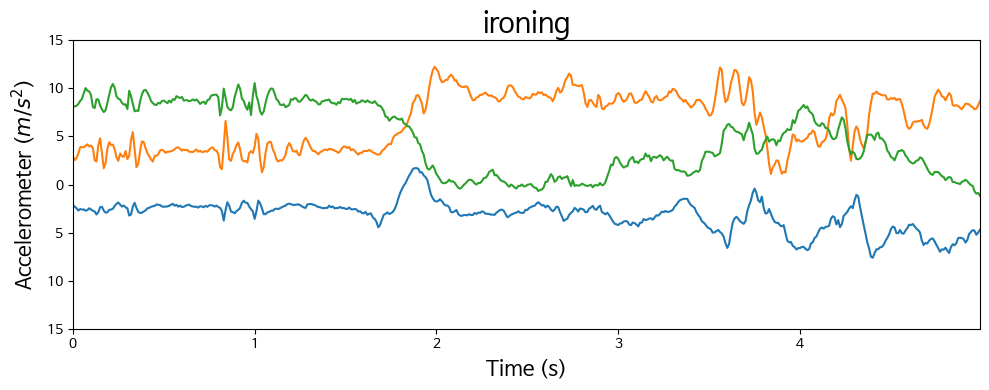

In [ ]:
FPS = 100

X_sample, Y_sample = X[0], Y[0]
time_stamps = np.arange(0, len(X_sample)) / FPS


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(time_stamps, X_sample)

ax.set_title(Y_sample, fontsize=20)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)
ax.set_xlim(min(time_stamps), max(time_stamps))
ax.set_ylim(-15, 15)

fig.tight_layout()
fig.show()

# Clssification할때는 Feature를 뽑아서 해야함. 평균, 편차, FFT의 주기 등등...

IndexError: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


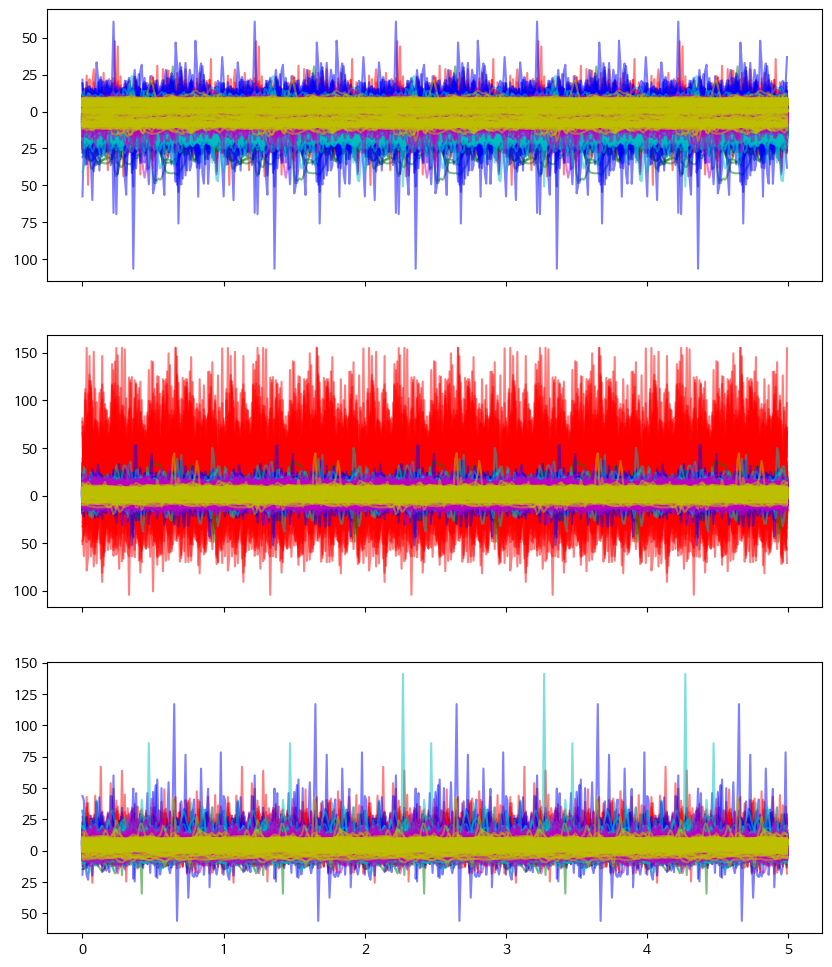

In [ ]:
FPS = 100

# 로드한 데이터
X, Y, groups = load_data(local=False)

# 시간 정보 계산
time_stamps = np.arange(0, len(X[0])) / FPS

# Y 값 종류별로 데이터를 분리합니다.
unique_Y = np.unique(Y)

# 그래프를 그릴 색상 리스트
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# 그래프 생성
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Y 값 종류별로 그래프를 그리고 여러 사용자의 데이터를 누적해서 그립니다.
for i, y_val in enumerate(unique_Y):
    # Y 값이 해당 y_val인 데이터를 선택합니다.
    y_mask = (Y == y_val)
    x_data = X[y_mask]

    # 각 축의 데이터를 가져옵니다.
    x_axis = x_data[:, :, 0]  # x 축 데이터
    y_axis = x_data[:, :, 1]  # y 축 데이터
    z_axis = x_data[:, :, 2]  # z 축 데이터

    # 그래프를 그립니다.
    axs[0].plot(time_stamps, x_axis.T, color=colors[i], alpha=0.5, label=f"Motion: {y_val}")
    axs[1].plot(time_stamps, y_axis.T, color=colors[i], alpha=0.5, label=f"Motion: {y_val}")
    axs[2].plot(time_stamps, z_axis.T, color=colors[i], alpha=0.5, label=f"Motion: {y_val}")

# 그래프 설정
axs[0].set_ylabel('X axis ($m/s^2$)', fontsize=15)
axs[1].set_ylabel('Y axis ($m/s^2$)', fontsize=15)
axs[2].set_ylabel('Z axis ($m/s^2$)', fontsize=15)
axs[2].set_xlabel('Time (s)', fontsize=15)

# 그래프의 제목을 추가합니다.
axs[0].set_title("Accelerometer Data by Motion Type (X axis)", fontsize=20)
axs[1].set_title("Accelerometer Data by Motion Type (Y axis)", fontsize=20)
axs[2].set_title("Accelerometer Data by Motion Type (Z axis)", fontsize=20)

# 범례 추가
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')

fig.tight_layout()
plt.show()


### 3. `KNNClassifier` 예제
- 이 예제는 예시일 뿐이고, 다른 방식으로 구현하셔도 됩니다. 채점기준을 참고해주세요.

```python
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]
    
    mean = np.mean(X_sample, axis=0)
    std = np.std(X_sample, axis=0)
    
    features = np.hstack([mean, std])
    return features


def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])


# Example Classifier
# You can use python class instance instead of the Pipeline.
KNNClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA()),
    ('classifier', KNeighborsClassifier()),
])
```

#### `KNNClassifier` 구현 순서
##### a. `extract_features_from_a_single_sample`
- (500, 3) 크기의 데이터 샘플 하나를 입력받아 특성들을 1D numpy array로 반환합니다.
- 주어진 예제에서는 `mean`, `std` 특성들을 뽑아내고 있습니다.
- 추가적인 특성들을 구현할 때 아래 목록을 참고하실 수 있습니다.
  - Time Domain 특성
    - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, cross-correlation of axes, ...
  - Frequency Domain 특성
    - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...

##### b. 전처리기 (Preprocessor) 추가
- a.에서 뽑아낸 특성들을 전처리합니다.
- 주어진 예제에는 `PCA`가 포함되어 있습니다.
- 아래 링크에서 `sklearn`이 제공하는 전처리기 목록을 확인하실 수 있습니다.
  - [`sklearn.preprocessing` documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
- `sklearn` 외의 라이브러리를 이용하셔도 됩니다.


##### c. 분류기 튜닝
- a.에서 어떤 특성을 사용할지, b.에서 어떤 전처리기를 사용할지, 전처리기/분류기의 하이퍼파라미터를 어떻게 정할지 등을 바꾸어가며 성능을 높입니다.
- Cross Validation을 이용해서 테스트 결과를 예측하며 하이퍼파라미터를 설정할 수 있습니다.
- 자세한 튜닝 방법은 `CrossValidation.ipynb`를 참고해주세요.

### 4. 구현

In [ ]:
# 2. Factorize 'Y: Motion' Column

import pandas as pd

df = pd.DataFrame(Y)
df[0], Motion = df[0].factorize()
print(Motion)

df

Index(['ironing', 'standing', 'descending stairs', 'lying', 'ascending stairs',
       'sitting', 'walking', 'vacuum cleaning', 'cycling', 'Nordic walking',
       'rope jumping', 'running'],
      dtype='object')


,0
0,0
1,0
2,0
3,0
4,0
...,...
13935,10
13936,10
13937,10
13938,10


In [ ]:
Y

array(['ironing', 'ironing', 'ironing', ..., 'rope jumping',
       'rope jumping', 'rope jumping'], dtype='<U17')

In [ ]:
############################################################
# Implement your own LRClassifier in this cell

import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


def extract_features_from_a_single_sample(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:]

    # X_fft를 1차원으로 축소
    pca = PCA(n_components=1)
    X_fft_reduced = pca.fit_transform(X_fft)

    # mean = np.mean(X_sample, axis=0)
    # std = np.std(X_sample, axis=0)

    # features = np.hstack([mean, std, X_fft_reduced.ravel()])


    mean_x = np.mean(X_sample[:, 0])  # 평균 (mean) - x 축의 데이터를 가져옵니다.
    std_y = np.std(X_sample[:, 1])  # 표준 편차 (stddev) - y 축의 데이터를 가져옵니다.
    quartile_z = np.percentile(X_sample[:, 2], 25)  # 1분위수 (1st quartile) - z 축의 25% 지점의 값을 가져옵니다.

    features = np.array([mean_x, std_y, quartile_z])


    return features


def extract_features_from_multiple_samples(X_samples: np.ndarray) -> np.ndarray:
    """
    Extract features from multiple samples

    Parameters
    ----------
    X_samples : array of shape (n, 500, 3)
        List of data samples

    Returns
    -------
    array of shape (n, p)
        Extracted features from X_samples
    """
    return np.asarray([extract_features_from_a_single_sample(X_sample) for X_sample in X_samples])



# Logistic Regression Classifier
LRClassifier = Pipeline([
    ('feature_extractor', FunctionTransformer(extract_features_from_multiple_samples)),
    ('preprocessor', PCA(n_components=0.95)),
    ('classifier', LogisticRegression(max_iter=1000)),
])

############################################################

### 5. Cross-validation with subjects

In [ ]:
X, Y, groups = load_data(local=False)

# Scoring
scores = cross_val_score(
    LRClassifier,
    X, Y, groups=groups,
    scoring='f1_macro',
    cv=LeaveOneGroupOut())
print(np.mean(scores))

0.4940829382806277


mean, std : 0.4453502581198664

mean, std, X_fft.ravel() : 0.5112480347923775

mean, std, X_fft_reduced.ravel() : 0.4696905832290263

[mean_x, std_y, quartile_z : 0.4940829382806277